In [1]:
import glob
import os
import random
import xarray as xr
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks, Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

nb='/home/afahad/nb/subgrid_tend/model/'
# Enable GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"Using {len(gpus)} GPU(s)")
else:
    print("No GPUs found, using CPU.")

# Multi-GPU strategy
strategy = tf.distribute.MirroredStrategy()
print(f"Replicas: {strategy.num_replicas_in_sync}")

# Pearson correlation metric
def correlation_metric(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    mean_true = tf.reduce_mean(y_true_flat)
    mean_pred = tf.reduce_mean(y_pred_flat)
    cov = tf.reduce_mean((y_true_flat - mean_true) * (y_pred_flat - mean_pred))
    std_true = tf.sqrt(tf.reduce_mean((y_true_flat - mean_true)**2))
    std_pred = tf.sqrt(tf.reduce_mean((y_pred_flat - mean_pred)**2))
    return cov / (std_true * std_pred + tf.keras.backend.epsilon())


Using 1 GPU(s)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Replicas: 1


In [2]:
import numpy as np
import xarray as xr

def reshape_to_blocks(var, face_y_chunk=30, x_chunk=15):
    """
    Reshape a DataArray with dims (time, lev, face, y, x) into
    (block, face_y, x, lev), where:
      block = time * (face*y // face_y_chunk) * (x // x_chunk)
      face_y = face_y_chunk
      x      = x_chunk
      lev    preserved as channel dim at the end

    Parameters
    ----------
    var : xarray.DataArray
        Input array, must have dims ("time","lev","face","y","x").
    face_y_chunk : int
        Size of each chunk along the stacked (face,y) dimension.
    x_chunk : int
        Size of each chunk along the x dimension.

    Returns
    -------
    xarray.DataArray
        4-D array with dims ("block","face_y","x","lev").
    """
    # 1) stack face & y, and bring dims into a known order
    X = var.stack(face_y=("face","y")).transpose("time","lev","face_y","x")

    # 2) compute how many chunks along face_y and x
    n_fy_chunks = X.sizes["face_y"] // face_y_chunk
    n_x_chunks  = X.sizes["x"]      // x_chunk

    # 3) reshape into 6-D: (time, lev, nchunk, face_y, nchunk_x, x)
    arr = X.data.reshape(
        X.sizes["time"],
        X.sizes["lev"],
        n_fy_chunks,    face_y_chunk,
        n_x_chunks,     x_chunk
    )

    # 4) wrap back into xarray and assign coords
    Y = xr.DataArray(
        arr,
        dims=("time","lev","nchunk","face_y","nchunk_x","x"),
        coords={
            "time":     X.coords["time"],
            "lev":      X.coords["lev"],
            "nchunk":   np.arange(n_fy_chunks),
            "face_y":   np.arange(face_y_chunk),
            "nchunk_x": np.arange(n_x_chunks),
            "x":        np.arange(x_chunk),
        }
    )

    # 5) move (time, nchunk, nchunk_x) into a single "block" axis,
    #    leave lev till last so it can act as channels
    result = (
        Y
        .transpose("time","nchunk","nchunk_x","face_y","x","lev")
        .stack(block=("time","nchunk","nchunk_x"))
        .transpose("block","face_y","x","lev")
    )

    return result

In [3]:
ds=xr.open_mfdataset('/home/afahad/nb/subgrid_tend/6km/Ttrain_*202001*.nc4')
n=ds.dT.shape[0]; nl=ds.dT.shape[1]; nf=ds.dT.shape[2]; nx=ds.dT.shape[3]; ny=ds.dT.shape[4]
#X= reshape_to_blocks(ds.dT, face_y_chunk=30, x_chunk=15)
#Y= reshape_to_blocks(ds.subT, face_y_chunk=30, x_chunk=15)

In [4]:
X1=ds.subT
X2=ds.T
Y=ds.dT

In [5]:
# Define the coordinate values
face_coord = np.arange(1, 7)           # [1, 2, 3, 4, 5, 6]
y_coord = np.arange(90)               # [0, 1, …, 89]
x_coord = np.arange(90)               # [0, 1, …, 89]
n=len(Y)
# Create a (6,1,1) array of face values, then broadcast to (6,90,90)
face = face_coord[ None,:, None, None, None] * np.ones((n,6, 90, 90, 52))
xdata = x_coord[ None,None, None, :, None] * np.ones((n,6, 90, 90, 52))
ydata = y_coord[ None,None, :, None, None] * np.ones((n,6, 90, 90, 52))

In [6]:
face=np.reshape(face,(n*nf*ny*nx,nl))
xdata=np.reshape(xdata,(n*nf*ny*nx,nl))
ydata=np.reshape(ydata,(n*nf*ny*nx,nl))

In [7]:
face_min, face_max   = face.min(),   face.max()
xdata_min, xdata_max = xdata.min(), xdata.max()
ydata_min, ydata_max = ydata.min(), ydata.max()

# 2) min–max normalize into [0,1], overwriting the originals
face  = (face  - face_min)  / (face_max  - face_min)
xdata = (xdata - xdata_min) / (xdata_max - xdata_min)
ydata = (ydata - ydata_min) / (ydata_max - ydata_min)

In [8]:
X1=X1.compute()
X2=X2.compute()
Y=Y.compute()

In [9]:
# X=(X
#     .stack(face_y=("face","y"))
#     .transpose("time","face_y","x","lev")
# )
# Y=(Y
#     .stack(face_y=("face","y"))
#     .transpose("time","face_y","x","lev")
# )

In [9]:
# compute global min & max
X1_min, X1_max = X1.min(), X1.max()
X2_min, X2_max = X2.min(), X2.max()
Y_min, Y_max = Y.min(), Y.max()

# min–max normalize into [0,1]
Xn1 = (X1 - X1_min) / (X1_max - X1_min)
Xn2 = (X2 - X2_min) / (X2_max - X2_min)
Yn = (Y - Y_min) / (Y_max - Y_min)

In [10]:
Xn=xr.concat([Xn1,Xn2],dim='lev')

In [11]:
# np.savez(nb+'XY.npz',Xn=Xn, Yn=Yn, X_mean=X_mean, X_std=X_std, Y_mean=Y_mean, Y_std=Y_std)
#np.savez(nb+'XY.npz',Xn=Xn, Yn=Yn, X_min=X_min, X_max=X_max, Y_min=Y_min, Y_max=Y_max)


In [12]:
# ds=np.load(nb+'XY.npz')
# Xn=ds['Xn']
# Yn=ds['Yn']

In [13]:
Xn=(Xn
    .stack(face_y=("face","y"))
    .transpose("time","face_y","x","lev")
)
Yn=(Yn
    .stack(face_y=("face","y"))
    .transpose("time","face_y","x","lev")
)

In [14]:
Xn=np.reshape(Xn.data,(n*nf*ny*nx,nl*2))
Yn=np.reshape(Yn.data,(n*nf*ny*nx,nl))

In [15]:
Xn=np.concatenate((Xn,face,xdata, ydata),axis=-1) 

In [16]:
# del X, Y

In [17]:
n = len(Xn); blocks = np.arange(n)

# split 80% train / 20% test
train_idx, test_idx = train_test_split(
    blocks,
    train_size=0.8,
    random_state=42,   # for reproducibility
    shuffle=True)

# select your splits
# X_train = Xn[train_idx,:,:,:]; X_test  = Xn[test_idx,:,:,:]
# Y_train = Yn[train_idx,:,:,:]; Y_test  = Yn[test_idx,:,:,:]
X_train = Xn[train_idx,:]; X_test  = Xn[test_idx,:]
Y_train = Yn[train_idx,:]; Y_test  = Yn[test_idx,:]

In [18]:
del Xn, Yn

In [19]:
print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("   min/max X:", X_train.min().item(), X_train.max().item())
print("   unique X values:", np.unique(X_train[:10,1]))

print("   min/max Y:", Y_train.min().item(), Y_train.max().item())
print("   unique Y values:", np.unique(Y_train[:10,1]))

X_train: (11275200, 260) Y_train: (11275200, 52)
   min/max X: 0.0 1.0
   unique X values: [0.40593715 0.41253555 0.41877239 0.51277698 0.52543145 0.53637982
 0.54540743 0.55779072 0.56429873 0.58978844]
   min/max Y: 0.0 0.9681798837857456
   unique Y values: [0.4776504  0.48408738 0.48980507 0.49011857 0.51976543 0.52446059
 0.53634277 0.53725617 0.56706711 0.59656895]


In [20]:
# from tensorflow.keras import layers, models
# nf = 3  # number of input features
# # Define the input shape
# input_shape = (540, 90, nf)

# model = models.Sequential()

# # First convolutional layer with 32 filters, 3x3 kernel size
# model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
# model.add(layers.BatchNormalization())  # Helps in normalizing the activations and gradients

# # Second convolutional layer with 64 filters, 3x3 kernel size
# model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())

# # Additional convolutional layer with 128 filters
# model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())


# # Additional convolutional layer with 128 filters
# model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())

# # Additional convolutional layer with 128 filters
# model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())

# # Final layer to produce the output with `nv` channels
# model.add(layers.Conv2D(nf,(1, 1), activation='linear', padding='same'))

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=0.9)

# # Use this schedule in an optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# # Compile the model
# model.compile(optimizer=optimizer, loss='mse')

# # Display the model summary
# model.summary()



In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models

# number of input (and output) features
n_features = 52

# Learning-rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
# with strategy.scope():
    # Build the MLP
model = models.Sequential([
        # Input layer
        layers.Input(shape=(n_features*5,)),
    
        # Hidden layers
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
    
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
    
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),
    
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
    
        layers.Dropout(0.2),
    
        # Final output layer (linear activation for regression)
        layers.Dense(n_features, activation="linear"),
    ])
    
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               33408     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               6

In [21]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = (
    tf.data.Dataset
      .from_tensor_slices((X_train, Y_train))
      .shuffle(buffer_size=10_000, seed=42)   # shuffle your blocks
      .batch(batch_size)
      .prefetch(AUTOTUNE)
)


test_ds = (
    tf.data.Dataset
      .from_tensor_slices((X_test, Y_test))
      .shuffle(buffer_size=10_000, seed=42)   # shuffle your blocks
      .batch(batch_size)
      .prefetch(AUTOTUNE)
)

In [22]:
checkpoint_cb = callbacks.ModelCheckpoint(
    nb+'cnn2d_subgrid_best.h5', save_best_only=True,
    monitor='val_loss', mode='min', save_weights_only=False
)



In [23]:
ehistory = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=20,
        callbacks=[checkpoint_cb],
        verbose=1
    )

Epoch 1/20
352350/352350 [==============================] - 858s 2ms/step - loss: 3.1710e-04 - mae: 0.0113 - val_loss: 3.0716e-04 - val_mae: 0.0111
Epoch 6/20
352350/352350 [==============================] - 858s 2ms/step - loss: 3.1237e-04 - mae: 0.0112 - val_loss: 3.0452e-04 - val_mae: 0.0110
Epoch 7/20
352350/352350 [==============================] - 858s 2ms/step - loss: 3.0896e-04 - mae: 0.0111 - val_loss: 3.0469e-04 - val_mae: 0.0110
Epoch 8/20
352350/352350 [==============================] - 859s 2ms/step - loss: 3.0628e-04 - mae: 0.0111 - val_loss: 3.0506e-04 - val_mae: 0.0110
Epoch 9/20
352350/352350 [==============================] - 858s 2ms/step - loss: 3.0403e-04 - mae: 0.0111 - val_loss: 2.9715e-04 - val_mae: 0.0109
Epoch 10/20
352350/352350 [==============================] - 859s 2ms/step - loss: 3.0202e-04 - mae: 0.0110 - val_loss: 3.2735e-04 - val_mae: 0.0111
Epoch 11/20
352350/352350 [==============================] - 859s 2ms/step - loss: 3.0027e-04 - mae: 0.0110 - v

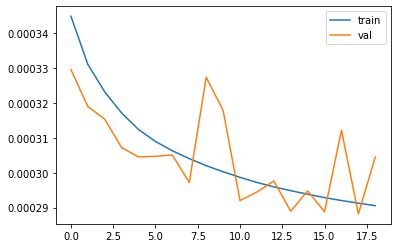

In [29]:
t=1
plt.figure(); plt.plot(ehistory.history['loss'][t:], label='train'); plt.plot(ehistory.history['val_loss'][t:], label='val'); plt.legend(); plt.show()


In [74]:
# Spatial comparison
i = random.choice(np.arange(len(true_vals)))
l = random.randint(0, nf-1)
true_map = true_vals[i,:,:,l]
pred_map = pred_vals[i,:,:,l]
vmin = true_map.min()
vmax = true_map.max()
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title(f'True Level {l}')
plt.imshow(true_map[:30,:15], origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(1,2,2)
plt.title(f'Pred Level {l}')
plt.imshow(pred_map[:30,:15], origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()


NameError: name 'true_vals' is not defined

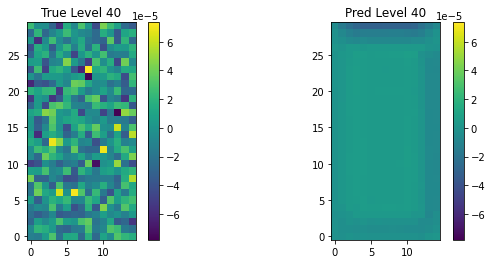

In [102]:
# Spatial comparison
i = random.choice(np.arange(len(true_vals)))
l = random.randint(0, nf-1)
true_map = true_vals[i,:,:,l]
pred_map = pred_vals[i,:,:,l]
vmin = true_map.min()
vmax = true_map.max()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title(f'True Level {l}')
plt.imshow(true_map, origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(1,2,2)
plt.title(f'Pred Level {l}')
plt.imshow(pred_map, origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()


In [32]:
# Evaluate on test dataset
res = model.evaluate(test_ds, verbose=0)
#print(f"Test MSE: {res:.4f}")

# Predict on test dataset


In [37]:
y_pred = model.predict(X_test[0:1,:])

In [38]:
test=Y_test[0:1,:]

In [40]:
y_pred=(y_pred * (Y_max.data - Y_min.data) + Y_min.data)
test=(test * (Y_max.data - Y_min.data) + Y_min.data)

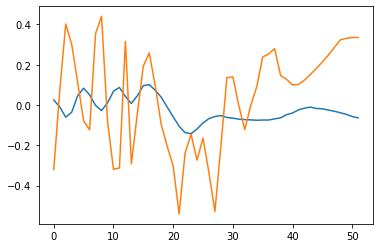

In [41]:
plt.plot(y_pred[0,:])
plt.plot(test[0,:])

In [30]:

# Denormalize predictions and true values
Y_max = Y_max#.data  # loaded earlier as scalar
Y_min = Y_min#.data
true_vals = (Y_test * (Y_max - Y_min) + Y_min)#.data
pred_vals =  y_pred  * (Y_max - Y_min) + Y_min

# Flatten for metrics
y_true_flat = true_vals#.flatten()
y_pred_flat = pred_vals#.flatten()

# Additional metrics
rmse = np.sqrt(np.mean((y_pred_flat - y_true_flat)**2))
mae  = np.mean(np.abs(y_pred_flat - y_true_flat))
corr = np.corrcoef(y_true_flat, y_pred_flat)[0,1]
print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}, Corr: {corr:.4f}")

# Scatter plot of True vs Predicted
plt.figure(figsize=(6,6))
sample_idx = np.random.choice(len(y_true_flat), size=min(10000, len(y_true_flat)), replace=False)
plt.scatter(y_true_flat[sample_idx], y_pred_flat[sample_idx], s=1, alpha=0.3)
mn, mx = y_true_flat.min(), y_true_flat.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs. Pred Scatter')
plt.show()

# Residual histogram
plt.figure()
plt.hist(y_pred_flat - y_true_flat, bins=50)
plt.title('Residual (Pred - True) Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()


ValueError: applied function returned data with unexpected number of dimensions. Received 2 dimension(s) but expected 0 dimensions with names: ()